# Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

from scipy.io import loadmat
import pandas as pd
import neurokit2 as nk
import numpy as np

from sklearn.ensemble import IsolationForest

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Display Modalities

In [2]:
path = "D:\Studium\Master\Masterarbeit\datasets\XITE"
subject = "S001"

In [3]:
sampling_rate = loadmat(path + "\Label\\" + subject + ".mat")["fs"][0,0]
stimulus_timestamps = pd.read_csv(path + "\Stimulus\\"+subject+".tsv", sep='\t')
biodata = loadmat(path + "\Bio\\"+subject+".mat")["data_stimuli"]
event_conditions = stimulus_timestamps["label"]
biodata = {"cor": biodata[:, 0],
           "zyg": biodata[:, 1],
           "eda": biodata[:, 3],
           "ecg": biodata[:, 4],
           "stimuli": biodata[:, 5]}

In [4]:
stimulus_timestamps = (stimulus_timestamps["time"]/1000).round().astype("int32")

In [5]:
start = stimulus_timestamps[0]-2000
end = stimulus_timestamps[0]+8000

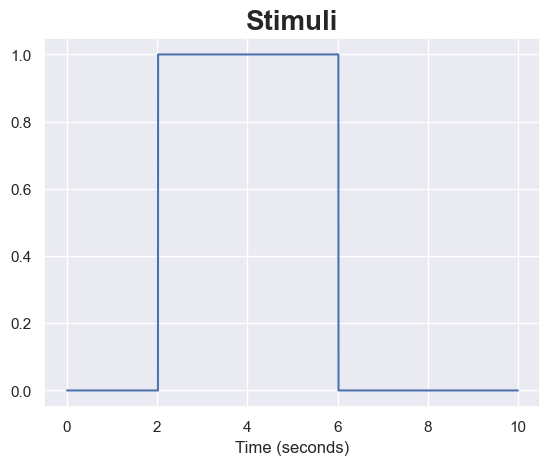

In [8]:
plt.plot(biodata["stimuli"][start:end])
plt.title("Stimuli", fontweight="bold", fontsize=20)
plt.xticks([0, 2000, 4000, 6000, 8000, 10000], [0, 2, 4, 6, 8, 10])
plt.xlabel("Time (seconds)")
plt.show()

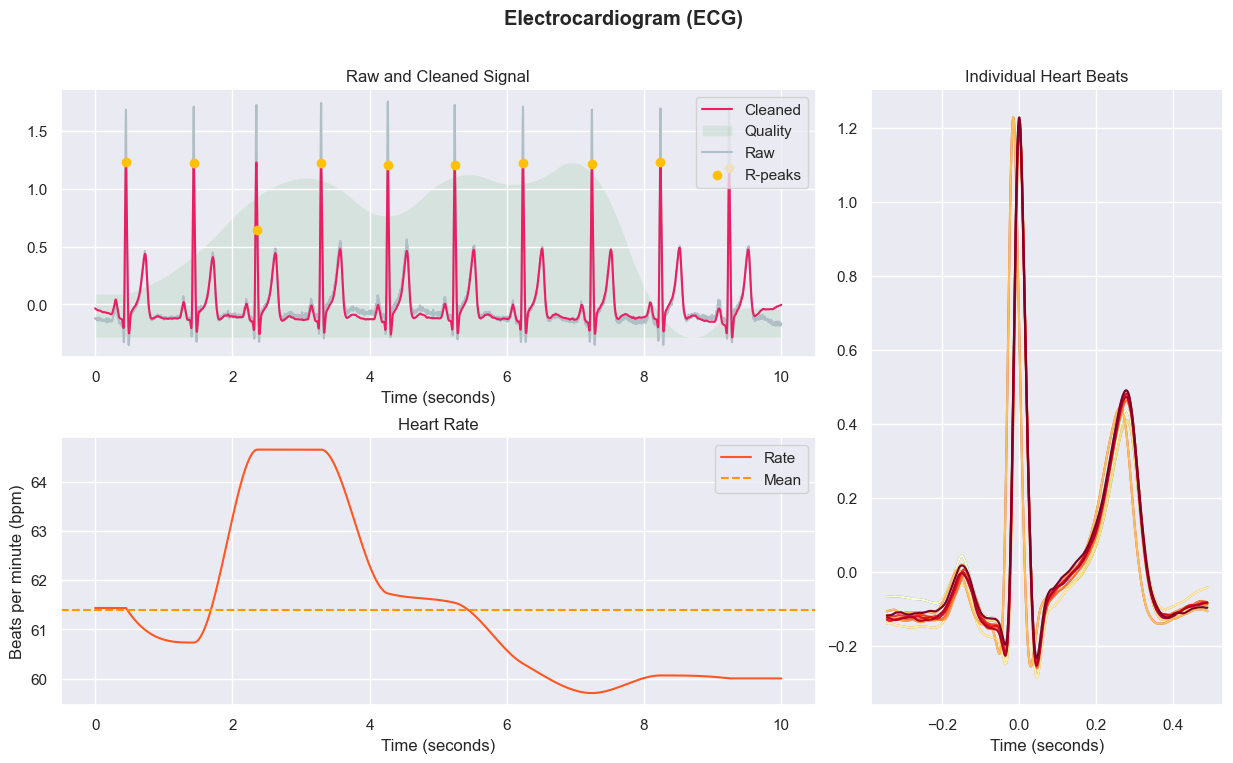

In [7]:
ecg_signals, _ = nk.ecg_process(biodata["ecg"][start:end], sampling_rate=sampling_rate)
nk.ecg_plot(ecg_signals, sampling_rate=sampling_rate, show_type='default')
fig = plt.gcf()
fig.set_figheight(8)
fig.set_figwidth(15)

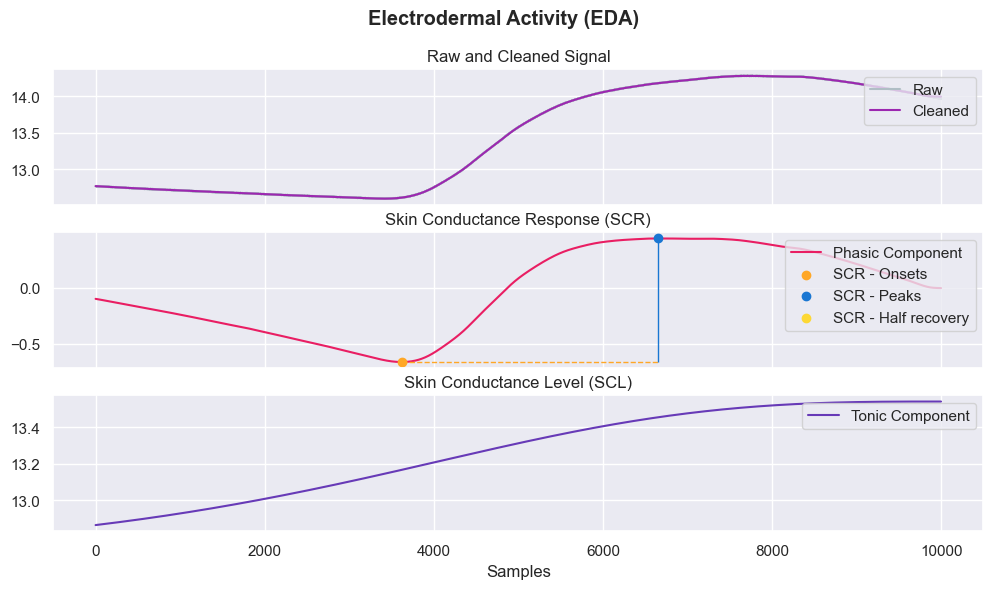

In [8]:
eda_signals, info = nk.eda_process(biodata["eda"][start:end], sampling_rate=sampling_rate)
nk.eda_plot(eda_signals)
fig = plt.gcf()
fig.set_figheight(6)
fig.set_figwidth(12)

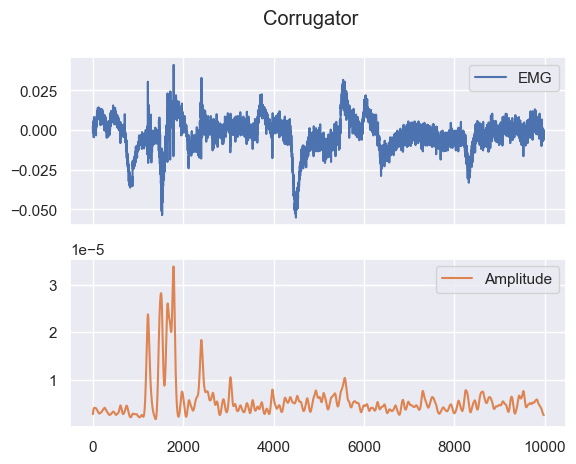

In [9]:
cleaned = nk.emg_clean(biodata["cor"][start:end], sampling_rate=sampling_rate)
amplitude = nk.emg_amplitude(cleaned)
ax1 = pd.DataFrame({"EMG": biodata["cor"][start+20:end], "Amplitude": amplitude[20:]}).plot(subplots=True, title="Corrugator")

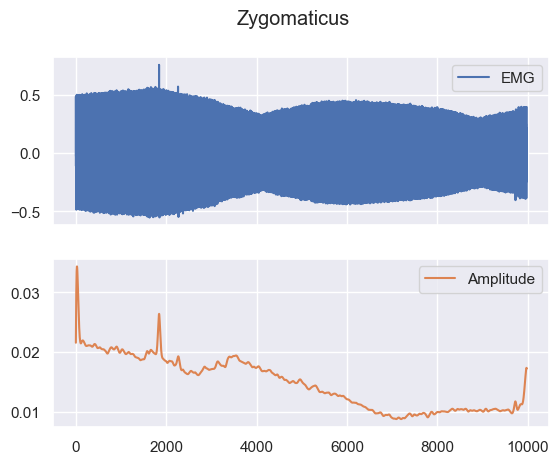

In [10]:
cleaned = nk.emg_clean(biodata["zyg"][start:end], sampling_rate=sampling_rate)
amplitude = nk.emg_amplitude(cleaned)
ax2 = pd.DataFrame({"EMG": biodata["zyg"][start+20:end], "Amplitude": amplitude[20:]}).plot(subplots=True, title="Zygomaticus")

# Display Dataset

In [17]:
path_dataset = "D:\Workspace\workspace_masterarbeit\PainLevelShiftDetection\FeatureGeneration\dataset_processed\XITE\\normalized_subjects.pkl"
data = pd.read_pickle(path_dataset)

In [12]:
print("dataset length:", len(data))
print("pain samples:", data.groupby(['pain'])['pain'].count()[1])
print("no pain samples:", data.groupby(['pain'])['pain'].count()[0])
print("number subjects:", data["subject"].nunique())
print("samples per subject (mean):", round(data.groupby(['subject'])['subject'].count().mean(), 2))

dataset length: 48201
pain samples: 24102
no pain samples: 24099
number subjects: 130
samples per subject (mean): 370.78


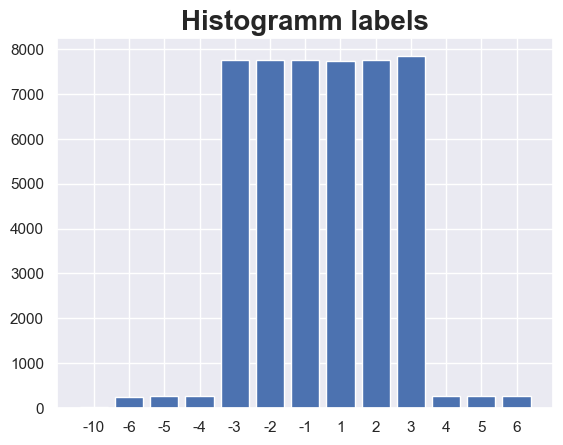

In [13]:
# Make a random dataset:
height = data.groupby(['label'])['label'].count()
bars = data["label"].unique()
bars.sort()
y_pos = np.arange(len(bars))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.title("Histogramm labels", fontweight="bold", fontsize=20)
plt.show()

# Outlier Detection

##### pain

In [18]:
data_pain = data[data["pain"]==1]
data_pain = data_pain.drop(["pain", "subject", "label"], axis=1)
clf_pain = IsolationForest(random_state=0).fit(data_pain)
pred_pain = clf_pain.predict(data_pain)
print("percentage of none outliers:", round(100*sum(pred_pain>0)/len(data_pain), 3))

percentage of none outliers: 93.038


##### no pain

In [19]:
data_nopain = data[data["pain"]==0]
data_nopain = data_nopain.drop(["pain", "subject", "label"], axis=1)
clf_nopain = IsolationForest(random_state=0).fit(data_nopain)
pred_nopain = clf_nopain.predict(data_nopain)
print("percentage of none outliers:", round(100*sum(pred_nopain>0)/len(data_nopain), 3))

percentage of none outliers: 96.51
